<a href="https://colab.research.google.com/github/omiyawaki/miyawaki-2025-nonmonotonic-moist-adiabat/blob/main/Figure_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[2025-06-18 13:35:33] Starting sensitivity contour plot generation...
[2025-06-18 13:35:33] Processing Ts = 280.0 K...
[2025-06-18 13:35:33] Processing Ts = 281.0 K...
[2025-06-18 13:35:33] Processing Ts = 282.0 K...
[2025-06-18 13:35:33] Processing Ts = 283.0 K...
[2025-06-18 13:35:33] Processing Ts = 284.0 K...
[2025-06-18 13:35:33] Processing Ts = 285.0 K...
[2025-06-18 13:35:33] Processing Ts = 286.0 K...
[2025-06-18 13:35:33] Processing Ts = 287.0 K...
[2025-06-18 13:35:33] Processing Ts = 288.0 K...
[2025-06-18 13:35:33] Processing Ts = 289.0 K...
[2025-06-18 13:35:33] Processing Ts = 290.0 K...
[2025-06-18 13:35:33] Processing Ts = 291.0 K...
[2025-06-18 13:35:33] Processing Ts = 292.0 K...
[2025-06-18 13:35:34] Processing Ts = 293.0 K...
[2025-06-18 13:35:34] Processing Ts = 294.0 K...
[2025-06-18 13:35:34] Processing Ts = 295.0 K...
[2025-06-18 13:35:34] Processing Ts = 296.0 K...
[2025-06-18 13:35:34] Processing Ts = 297.0 K...
[2025-06-18 13:35:34] Processing Ts = 298.0 K...

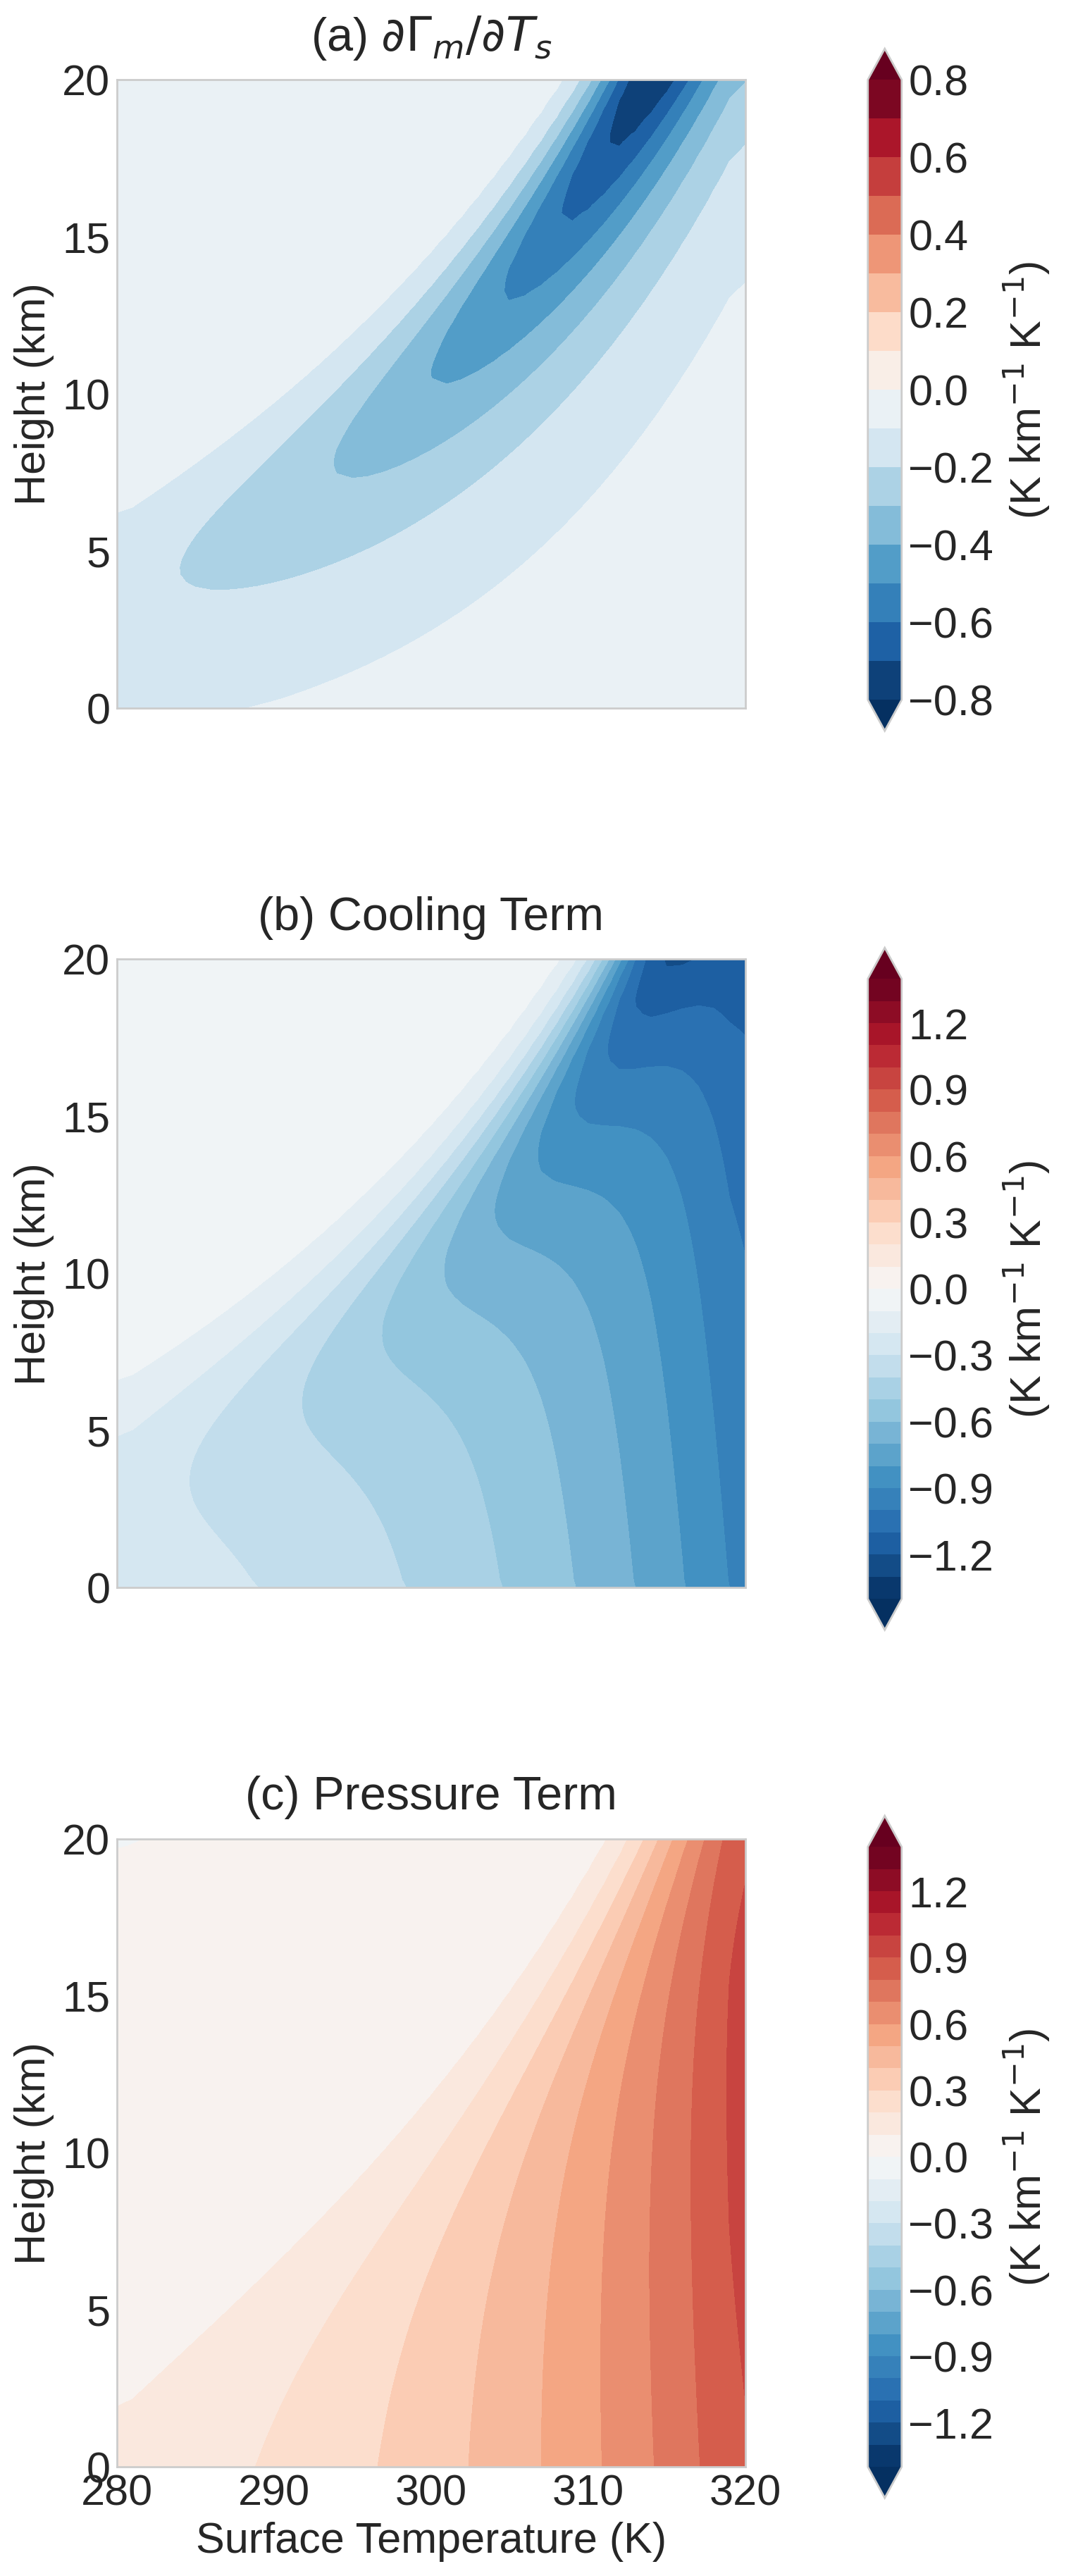

Figure 2 saved as figure_2_sensitivity_decomposition_final.png


In [1]:
# ==============================================================================
# SCRIPT TO CREATE FIGURE 2:
# DECOMPOSITION OF THE MOIST ADIABATIC LAPSE RATE SENSITIVITY
#
# This script creates a central three-panel figure for the manuscript's core
# argument. It visualizes the sensitivity of the moist adiabatic lapse rate,
# d(Gamma_m)/dTs, as a function of height and surface temperature.
#
# It then provides a physical explanation for this structure by showing an
# approximate, additive decomposition of the sensitivity into a "Cooling Term"
# and a "Pressure Term".
#
# The script performs the following actions:
# 1. Defines thermodynamic constants and functions for a moist atmosphere.
# 2. Implements a function to calculate moist adiabatic temperature profiles.
# 3. For a range of surface temperatures (Ts), it computes profiles
#    of the sensitivity and its component terms.
# 4. It interpolates these profiles onto a regular grid of height and Ts.
# 5. Finally, it generates a three-panel filled contour plot showing:
#    (a) The total sensitivity, constructed from the sum of the components.
#    (b) The contribution from the "Cooling Term".
#    (c) The contribution from the "Pressure Term".
# ==============================================================================

# For sharper inline plots in Jupyter environments
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.interpolate import interp1d
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
Lv_const = 2.501e6  # Latent heat of vaporization (J/kg)

# --- Core Thermodynamic & Profile Functions ---

def saturation_vapor_pressure(T):
    """Calculates saturation vapor pressure (es) in Pa."""
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    """Calculates saturation specific humidity (qs) in kg/kg."""
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    denominator = np.maximum(denominator, 1e-3)
    qs = epsilon * es / denominator
    return np.maximum(qs, 0.0)

def dq_dT_p(p, T):
    """Numerically calculates the partial derivative (dq_s/dT)_p."""
    delta_T = 0.01 # Small temperature perturbation
    qs_plus = saturation_specific_humidity(p, T + delta_T)
    qs_minus = saturation_specific_humidity(p, T - delta_T)
    return (qs_plus - qs_minus) / (2 * delta_T)

def dq_dp_T(p, T):
    """Numerically calculates the partial derivative (dq_s/dp)_T."""
    delta_p = 10.0 # Small pressure perturbation (in Pa)
    qs_plus = saturation_specific_humidity(p + delta_p, T)
    qs_minus = saturation_specific_humidity(p - delta_p, T)
    return (qs_plus - qs_minus) / (2 * delta_p)

def moist_lapse_rate_from_profile(T, z):
    """Calculates Gamma_m from a temperature profile via finite difference."""
    dz = z[1] - z[0]
    return -np.gradient(T, dz)

def calculate_mse(T, p, z):
    """Calculates Moist Static Energy (MSE) in J/kg."""
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv_const * qs

def virtual_temperature(T, p):
    """Calculates virtual temperature (Tv) in K."""
    qs = saturation_specific_humidity(p, T)
    return T * (1.0 + (1.0 / epsilon - 1.0) * qs)

def calculate_moist_adiabatic_profile(T_surf, p_surf, z_max, dz):
    """Calculates z, T, and p profiles by conserving MSE."""
    n_steps = int(z_max / dz) + 1
    z_profile = np.linspace(0, z_max, n_steps)
    T_profile, p_profile = np.full(n_steps, np.nan), np.full(n_steps, np.nan)
    T_profile[0], p_profile[0] = T_surf, p_surf
    mse_conserved = calculate_mse(T_profile[0], p_profile[0], 0.0)
    for i in range(n_steps - 1):
        z_c, T_c, p_c = z_profile[i], T_profile[i], p_profile[i]
        if np.isnan(T_c) or p_c <= 0: break
        z_n = z_profile[i+1]
        Tv_c = virtual_temperature(T_c, p_c)
        H = (Rd * Tv_c) / g
        p_n = p_c * np.exp(-dz / H)
        if p_n <= 0: break
        def res(T_g): return calculate_mse(T_g, p_n, z_n) - mse_conserved
        try:
            sol = root_scalar(res, bracket=[50.0, T_c + 5], method='brentq')
            if sol.converged: T_profile[i+1], p_profile[i+1] = sol.root, p_n
            else: break
        except (ValueError, RuntimeError): break
    valid = ~np.isnan(T_profile)
    return z_profile[valid], T_profile[valid], p_profile[valid]

def get_sensitivity_components(t_surf_k, p_surf_pa, z_max, dz):
    """
    Calculates the cooling and pressure components of dqs/dz.
    """
    z_base, t_base, p_base = calculate_moist_adiabatic_profile(t_surf_k, p_surf_pa, z_max, dz)

    if len(z_base) < 2:
        return z_base, None, None

    # Calculate profiles of Gamma_m and rho
    gamma_m_base = moist_lapse_rate_from_profile(t_base, z_base)
    Tv_base = virtual_temperature(t_base, p_base)
    rho_base = p_base / (Rd * Tv_base)

    # Calculate component profiles
    cooling_comp_profile = -gamma_m_base * dq_dT_p(p_base, t_base)
    pressure_comp_profile = -rho_base * g * dq_dp_T(p_base, t_base)

    return z_base, cooling_comp_profile, pressure_comp_profile

def main():
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Starting sensitivity contour plot generation...")

    # --- Parameters ---
    P_SURFACE_PA = 100000.0
    Z_MAX_M = 21000
    DZ_M = 250
    T_surf_range_K = np.arange(280, 320.1, 1.0)
    z_grid_km = np.arange(0, Z_MAX_M / 1000, DZ_M / 1000)

    # Initialize 2D arrays for the grids
    cooling_comp_grid = np.full((len(z_grid_km), len(T_surf_range_K)), np.nan)
    pressure_comp_grid = np.full((len(z_grid_km), len(T_surf_range_K)), np.nan)

    # --- Calculation Loop ---
    for i, t_surf_k in enumerate(T_surf_range_K):
        print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Processing Ts = {t_surf_k:.1f} K...")
        z, cooling, pressure = get_sensitivity_components(t_surf_k, P_SURFACE_PA, Z_MAX_M, DZ_M)
        if len(z) > 1:
            cooling_comp_grid[:, i] = interp1d(z, cooling, bounds_error=False, fill_value=np.nan)(z_grid_km * 1000)
            pressure_comp_grid[:, i] = interp1d(z, pressure, bounds_error=False, fill_value=np.nan)(z_grid_km * 1000)

    # --- Differentiate grids to get sensitivity of components ---
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Differentiating component grids...")
    d_cooling_comp_dT_grid = np.gradient(cooling_comp_grid, T_surf_range_K, axis=1)
    d_pressure_comp_dT_grid = np.gradient(pressure_comp_grid, T_surf_range_K, axis=1)

    # --- Construct Final Grids for Plotting ---
    # Apply the (Lv/cpd) factor and convert units from K/m/K to K/km/K by multiplying by 1000
    cooling_term_grid = (Lv_const / cpd) * d_cooling_comp_dT_grid * 1000
    pressure_term_grid = (Lv_const / cpd) * d_pressure_comp_dT_grid * 1000

    total_sens_grid_plot = cooling_term_grid + pressure_term_grid

    # --- Visualization ---
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Calculation complete. Generating plot...")

    T_grid_K, Z_grid_km = np.meshgrid(T_surf_range_K, z_grid_km)
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(3, 1, figsize=(8, 22), sharex=True)
    base_fontsize = 22

    plot_data = [
        {'grid': total_sens_grid_plot, 'title': r'(a) $\partial \Gamma_m / \partial T_{s}$'},
        {'grid': cooling_term_grid, 'title': '(b) Cooling Term'},
        {'grid': pressure_term_grid, 'title': '(c) Pressure Term'}
    ]

    levels_a = np.arange(-0.8, 0.81, 0.1)
    comp_levels = np.arange(-1.4, 1.41, 0.1)
    cmap = plt.get_cmap('RdBu_r')

    # Panel A
    contour_a = axes[0].contourf(T_grid_K, Z_grid_km, plot_data[0]['grid'], levels=levels_a, cmap=cmap, extend='both')
    axes[0].contour(T_grid_K, Z_grid_km, plot_data[0]['grid'], levels=[0], colors='k', linewidths=2)

    # Panel B
    contour_b = axes[1].contourf(T_grid_K, Z_grid_km, plot_data[1]['grid'], levels=comp_levels, cmap=cmap, extend='both')
    axes[1].contour(T_grid_K, Z_grid_km, plot_data[1]['grid'], levels=[0], colors='k', linewidths=2)

    # Panel C
    contour_c = axes[2].contourf(T_grid_K, Z_grid_km, plot_data[2]['grid'], levels=comp_levels, cmap=cmap, extend='both')
    axes[2].contour(T_grid_K, Z_grid_km, plot_data[2]['grid'], levels=[0], colors='k', linewidths=2)

    for i, ax in enumerate(axes):
        ax.set_title(plot_data[i]['title'], fontsize=base_fontsize + 2, pad=15)
        ax.tick_params(axis='both', which='major', labelsize=base_fontsize)
        ax.set_ylim(0, 20)
        ax.set_box_aspect(1)
        ax.set_ylabel('Height (km)', fontsize=base_fontsize)

    axes[2].set_xlabel('Surface Temperature (K)', fontsize=base_fontsize)

    fig.subplots_adjust(hspace=0.4, right=0.8)

    cax_a = fig.add_axes([0.85, 0.67, 0.03, 0.22])
    cax_b = fig.add_axes([0.85, 0.38, 0.03, 0.22])
    cax_c = fig.add_axes([0.85, 0.1, 0.03, 0.22])

    cbar_a = fig.colorbar(contour_a, cax=cax_a, orientation='vertical')
    cbar_b = fig.colorbar(contour_b, cax=cax_b, orientation='vertical')
    cbar_c = fig.colorbar(contour_c, cax=cax_c, orientation='vertical')

    cbar_label = '(K km$^{-1}$ K$^{-1}$)'
    cbar_a.set_label(cbar_label, fontsize=base_fontsize)
    cbar_b.set_label(cbar_label, fontsize=base_fontsize)
    cbar_c.set_label(cbar_label, fontsize=base_fontsize)

    for cbar in [cbar_a, cbar_b, cbar_c]:
        cbar.ax.tick_params(labelsize=base_fontsize)

    fig2_filename = "fig-2.png"
    plt.savefig(fig2_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Figure 2 saved as {fig2_filename}")


if __name__ == '__main__':
    main()
